__Notification__: This notebook show the model evaludation results of the models using MACCS fingerprint
- Use the my-rdkit-env environment

In [21]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn lib
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from joblib import dump, load

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 1. Import data

In [22]:
train_test_path = "../../data_for_modeling/train_test_data/new_HDAC2_train_test_data.xlsx"
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')
validation_dataset = pd.read_excel(train_test_path, sheet_name='validation_dataset')

In [23]:
print(len(train_dataset), len(test_dataset), len(validation_dataset))

1966 421 422


In [24]:
from tabulate import tabulate
def check_activity_distribution(dataset, col_name):
    active_rows = dataset.loc[dataset[col_name] == "active"]
    inactive_rows = dataset.loc[dataset[col_name] == "inactive"]

    dataset_length = len(dataset)

    print(f"Total dataset: {dataset_length}")
    table = [['', 'active', 'inactive'], 
            ['Number', len(active_rows), len(inactive_rows)],
            ['Percentage (%)', len(active_rows)/dataset_length*100, len(inactive_rows)/dataset_length*100]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
check_activity_distribution(train_dataset, "Categories")
check_activity_distribution(test_dataset, "Categories")
check_activity_distribution(validation_dataset, "Categories")

Total dataset: 1966
╒════════════════╤══════════╤════════════╕
│                │   active │   inactive │
╞════════════════╪══════════╪════════════╡
│ Number         │ 634      │  1332      │
├────────────────┼──────────┼────────────┤
│ Percentage (%) │  32.2482 │    67.7518 │
╘════════════════╧══════════╧════════════╛
Total dataset: 421
╒════════════════╤══════════╤════════════╕
│                │   active │   inactive │
╞════════════════╪══════════╪════════════╡
│ Number         │ 137      │   284      │
├────────────────┼──────────┼────────────┤
│ Percentage (%) │  32.5416 │    67.4584 │
╘════════════════╧══════════╧════════════╛
Total dataset: 422
╒════════════════╤══════════╤════════════╕
│                │   active │   inactive │
╞════════════════╪══════════╪════════════╡
│ Number         │ 126      │   296      │
├────────────────┼──────────┼────────────┤
│ Percentage (%) │  29.8578 │    70.1422 │
╘════════════════╧══════════╧════════════╛


In [25]:
train_dataset.head()

,CID,SMILES,Categories,ZBG Classified,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,71465855,Nc1ccc(cc1NC(=O)N1CCOCC1)-c1cccs1,active,21,NaN,NaN,NaN
1,5281220,O=C1/C(=C/c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21,inactive,5,NaN,NaN,NaN
2,162654159,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,inactive,5,15.0,NaN,NaN
3,44571332,O=C(NO)c1ccc(CN2C(=O)CNC(=O)[C@H]2Cc2cccs2)cc1,inactive,1,15.0,NaN,NaN
4,130361881,O=C(NO)c1ccc(CN2CCCc3ccccc32)cc1,inactive,1,15.0,NaN,NaN


In [26]:
test_dataset.head()

,CID,SMILES,Categories,ZBG Classified,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,71465849,Nc1ccc(cc1NC(=O)N1CCC(F)C1)-c1cccs1,active,21,NaN,NaN,NaN
1,71465924,Nc1ccc(cc1NC(=O)OCC1CCNCC1)-c1cccs1,inactive,21,NaN,NaN,NaN
2,164624585,Cn1c(SCCCCCC(=O)Nc2ccccc2N)nnc1-c1ccncc1,inactive,4,9.0,15.0,20.0
3,118005720,O=C(NO)c1cnc(NC2(c3ccccc3)CCN(C(=O)Nc3cccc(F)c...,active,1,15.0,NaN,NaN
4,117829456,COc1ccc2cc(C(=O)NCCCCCCC(=O)NO)ccc2n1,active,1,15.0,NaN,NaN


# 2. Model training with MACCS fingerprint

## MACCS fingerprint encoding

In [27]:
#MACCS
from tqdm import tqdm

def maccs_fpts(data):
    Maccs_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = MACCSkeys.GenMACCSKeys(mol)
            mfpts = np.array(fpts)
            Maccs_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Maccs_fpts)

In [28]:
X_Train = maccs_fpts(train_dataset['SMILES'])
X_Test = maccs_fpts(test_dataset['SMILES'])
X_Validation = maccs_fpts(validation_dataset['SMILES'])

Progress:  13%|█▎        | 252/1966 [00:00<00:01, 1268.99it/s]

Progress: 100%|██████████| 422/422 [00:00<00:00, 1364.25it/s]


In [29]:
len(X_Train[0])

167

In [30]:
#y data
y_Train = np.array(train_dataset['Categories'])
y_Test = np.array(test_dataset['Categories'])
y_Validation = np.array(validation_dataset['Categories'])

#Original data
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

#One-hot encoder
import sklearn.preprocessing as preprocessing
lable_encoder = preprocessing.LabelEncoder()
y_Train = lable_encoder.fit_transform(y_Train)
y_Test = lable_encoder.transform(y_Test)
y_Validation = lable_encoder.transform(y_Validation)
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

['active' 'inactive' 'inactive' 'inactive' 'inactive']
['active' 'inactive' 'inactive' 'active' 'active']
['inactive' 'active' 'inactive' 'active' 'inactive']
[0 1 1 1 1]
[0 1 1 0 0]
[1 0 1 0 1]


## Model training

__Random Forest Classifier__

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_maccs = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_maccs.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=42)

__K Nearest Neighbor__

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn_maccs = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_maccs.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [33]:
from sklearn.svm import SVC
svm_maccs = SVC(kernel='rbf', probability=True, random_state=42)
svm_maccs.fit(X_Train, y_Train)

SVC(probability=True, random_state=42)

__XGBoost__

In [34]:
from xgboost import XGBClassifier
bst_maccs = XGBClassifier(objective='binary:logistic', tree_method = "hist", device="cpu")
bst_maccs.fit(X_Train, y_Train)

[11:20:18] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [35]:
#sklearn models -> use joblib
dump(rf_maccs, "../../results/models/rf_maccs.joblib")
dump(svm_maccs, "../../results/models/svm_maccs.joblib")
dump(knn_maccs, "../../results/models/knn_maccs.joblib")
#Xgboost
bst_maccs.save_model("../../results/models/xgboost_maccs.json")

# Reload models

In [36]:
bst_maccs = XGBClassifier(objective='binary:logistic', tree_method = "hist", device = "cpu")
bst_maccs.load_model("../../results/models/xgboost_maccs.json")

In [37]:
rf_maccs = load("../../results/models/rf_maccs.joblib")
svm_maccs = load("../../results/models/svm_maccs.joblib")
knn_maccs = load("../../results/models/knn_maccs.joblib")

# Model evaluation

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return ac, precision, recall, mcc, f1

def me_result(cm, model_name):
    cm_string = "Confusion matrix of " + model_name
    print(cm_string)
    print(cm)
    ac, se, sp, mcc, f1 = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [['Model', 'AC', 'SE', 'SP', 'MCC', 'F1'], [model_name, ac, se, sp, mcc, f1]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

### 1. Calculate all the evaluation metrics on test and validation dataset

In [39]:
X_Total = np.concatenate((X_Train, X_Validation), axis=0)
y_Total = np.concatenate((y_Train, y_Validation), axis=0)

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

cols = ['Model', 'Fingerprint', 
        '10-fold cross validation AC', 'Test-set Accuracy', 'Test-set Precision', 'Test-set Recall', 'Test-set MCC', 'Test-set F1', 'Test-set AUC', 
        'Training error', 'Test error', 'Validation error',
        'Validation-set Accuracy', 'Validation-set Precision', 'Validation-set Recall', 'Validation-set MCC', 'Validation-set F1', 'Validation-set AUC']

model_result = pd.DataFrame(columns=cols)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

for model_name in ['KNN', 'RF', 'SVM', 'XgBoost']:
    cv_scores = None
    y_pred_test = None
    y_pred_train = None
    y_pred_validation = None
    model = None
    
    if model_name == 'KNN':
        model = knn_maccs
    elif model_name == 'RF':
        model = rf_maccs
    elif model_name == 'SVM':
        model = svm_maccs
    elif model_name == 'XgBoost':
        model = bst_maccs
    else:
        print("Error")
    
    #Cross validation
    cv_scores = cross_val_score(model, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
    
     #Test set
    y_pred_test = model.predict(X_Test)
    y_proba_test = model.predict_proba(X_Test)[:, 1]
    auc_score_test = roc_auc_score(y_Test, y_proba_test)
    cm_test = confusion_matrix(y_Test, y_pred_test)
    test_ac, test_precision, test_recall, test_mcc, test_f1 = model_evaluation_calculation(cm_test)
    test_error = 1 - test_ac
    
    #validation set
    y_pred_validation = model.predict(X_Validation)
    y_proba_validation = model.predict_proba(X_Validation)[:, 1]
    auc_score_validation = roc_auc_score(y_Validation, y_proba_validation)
    cm_validation = confusion_matrix(y_Validation, y_pred_validation)
    validation_ac, validation_precision, validation_recall, validation_mcc, validation_f1 = model_evaluation_calculation(cm_validation)
    validation_error = 1 - validation_ac
    
    #train set
    y_pred_train = model.predict(X_Train)
    y_proba_train = model.predict_proba(X_Train)[:, 1]
    auc_score_train = roc_auc_score(y_Train, y_proba_train)
    cm_train = confusion_matrix(y_Train, y_pred_train)
    train_ac, _, _, _, _ = model_evaluation_calculation(cm_train)
    train_error = 1 - train_ac
    
    row_result = pd.DataFrame([[model_name, "MACCS", 
                                np.mean(cv_scores)*100, test_ac*100, test_precision*100, test_recall*100, test_mcc*100, test_f1*100, auc_score_test*100, 
                                train_error*100, test_error*100, validation_error*100,
                                validation_ac*100, validation_precision*100, validation_recall*100, validation_mcc*100, validation_f1*100, auc_score_validation*100]], 
                                columns=cols)
    
    model_result = pd.concat([model_result, row_result], ignore_index=True)

[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.
[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.


[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[11:20:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[11:20:36] WARNING: /croot/xgboo

In [41]:
model_result.head()

,Model,Fingerprint,10-fold cross validation AC,Test-set Accuracy,Test-set Precision,Test-set Recall,Test-set MCC,Test-set F1,Test-set AUC,Training error,Test error,Validation error,Validation-set Accuracy,Validation-set Precision,Validation-set Recall,Validation-set MCC,Validation-set F1,Validation-set AUC
0,KNN,MACCS,80.987131,81.947743,67.883212,74.400000,58.057022,70.992366,86.884445,12.105799,18.052257,19.668246,80.331754,65.873016,67.479675,52.727659,66.666667,85.916720
1,RF,MACCS,84.591787,83.610451,65.693431,80.357143,61.441498,72.289157,88.078287,1.271617,16.389549,16.824645,83.175355,65.873016,74.774775,58.637159,70.042194,88.466592
2,SVM,MACCS,81.574488,81.235154,51.094891,85.365854,55.450230,63.926941,84.636836,15.157681,18.764846,18.009479,81.990521,50.793651,82.051282,54.308213,62.745098,82.827917
3,XgBoost,MACCS,84.422664,84.323040,68.613139,80.341880,63.292102,74.015748,89.107639,1.729400,15.676960,16.587678,83.412322,66.666667,75.000000,59.291442,70.588235,87.670260


In [22]:
model_result.to_excel('../../results/model_results/20240301_maccs_model_result.xlsx')

### 2. ROC Curves

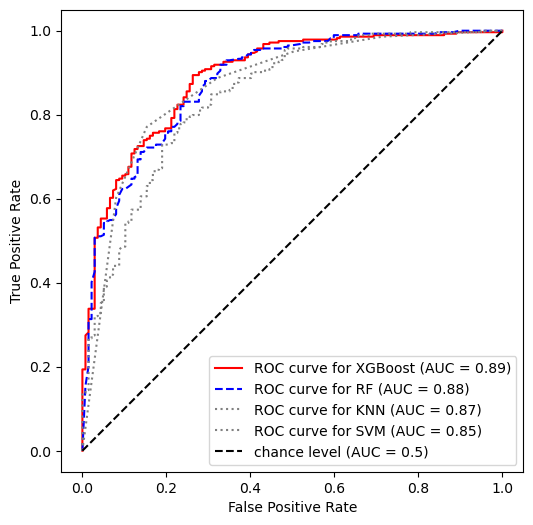

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=bst_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    linestyle="solid",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=rf_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    linestyle="dashed",
    color='blue',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=knn_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='gray',
    linestyle='dotted',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    linestyle='dotted',
    color='gray',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("MACCS fingerprint models ROC curves")
plt.legend()
plt.show()

In [24]:
knn_y_proba = knn_maccs.predict_proba(X_Test)[:, 1]
rf_y_proba = rf_maccs.predict_proba(X_Test)[:, 1]
svm_y_proba = svm_maccs.predict_proba(X_Test)[:, 1]
bst_y_proba = bst_maccs.predict_proba(X_Test)[:, 1]

knn_auc_score = roc_auc_score(y_Test, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.8688444535828108 0.8807828724169837 0.8463683561221342 0.8910763853192145
